*Mapping the network*

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point
# import copy

## Load data 
Data comes from http://stat-computing.org/dataexpo/2009/. 
Flight data relates to the year 2007 (see file Data_compiling) 

In [3]:
# Load airports data
Airports = pd.read_pickle("Airports.pkl")
print('Shape:', Airports.shape)
Airports.head(2)

Shape: (1512, 8)


,Airport_id,Name,City,Country,3DigitId,Lat,Lon,Altitude_ft
0,3411,Barter Island LRRS Airport,Barter Island,United States,BTI,70.134003,-143.582001,2
1,3412,Wainwright Air Station,Fort Wainwright,United States,\N,70.613403,-159.860001,35


In [5]:
# Load flights data
FlightsNx = pd.read_pickle("FlightsNx.pkl")
FlightsNx.tail(2)

,Origin,Dest,Distance,count,Origin_flights,Destination_flights,origin_degree,origin_degree_unn,dest_degree,dest_degree_unn
5340,PIR,JAX,1395,2,8,71860.0,0.006472,2.0,0.126214,39.0
5341,ANC,HNL,2777,23,39504,135193.0,0.097087,30.0,0.080906,25.0


## Implement as network. 
For function documentation, see:  
https://networkx.github.io/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_edgelist.html?highlight=from_pandas_edgelist#networkx.convert_matrix.from_pandas_edgelist

In [6]:
Network = nx.from_pandas_edgelist(FlightsNx, source = "Origin", target = "Dest", edge_attr = True)
print(nx.info(Network))

Name: 
Type: Graph
Number of nodes: 310
Number of edges: 2868
Average degree:  18.5032


## Mapping airport network geographically

In [40]:
# Get list of nodes, and add lat, lon from Airports dataset:
nodes = pd.DataFrame(list(Network.nodes()))
nodes.columns = ["3DigitId"]
positions = nodes.merge(Airports[["3DigitId","Lat","Lon"]], how = "left", on = "3DigitId")

# Positions for drawing
pos = {city:(long, lat) for (city, (lat,long)) in nx.get_node_attributes(Network, 'pos').items()}

# Create a positions dictionary, which is in the format necessary to add it as a node attribute.
pos_= dict()
for idx, row in positions.iterrows():
    pos_[row['3DigitId']] = dict(pos=(row['Lat'], row['Lon']))
    
# Set the node attributes. 
nx.set_node_attributes(Network, pos_)

attributes = positions.merge(FlightsNx[["Origin","Origin_flights","origin_degree_unn"]], how = "left", left_on = "3DigitId", right_on = "Origin").drop_duplicates()
attributes = attributes.sort_values(by = "origin_degree_unn", ascending = False)

In [84]:
# Split airports according to size/importance for plotting purposes:
hubs_small = list(attributes.loc[attributes["origin_degree_unn"]>25]["Origin"])
hubs = list(attributes.loc[attributes["origin_degree_unn"]>50]["Origin"])
hubs_large = list(attributes.loc[attributes["origin_degree_unn"]>100]["Origin"])

# Label large hubs for draw_networkx_labels
pos_large = dict((k, pos[k]) for k in hubs_large if k in pos)

TypeError: can only concatenate tuple (not "float") to tuple

In [ ]:
pos_large

In [83]:
pos_large

{'ATL': (-84.428101, 33.6367),
 'ORD': (-87.9048, 41.9786),
 'DFW': (-97.038002, 32.896801),
 'MSP': (-93.221802, 44.882),
 'SLC': (-111.97799682617188, 40.78839874267578),
 'DEN': (-104.672996521, 39.861698150635),
 'IAH': (-95.34140014648438, 29.98439979553223),
 'CVG': (-84.6678009033, 39.0488014221),
 'DTW': (-83.35340118408203, 42.212398529052734)}

In [42]:
# Get geographical file from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Select US: 
US = world[(world.pop_est>0) & (world.name == "United States")]

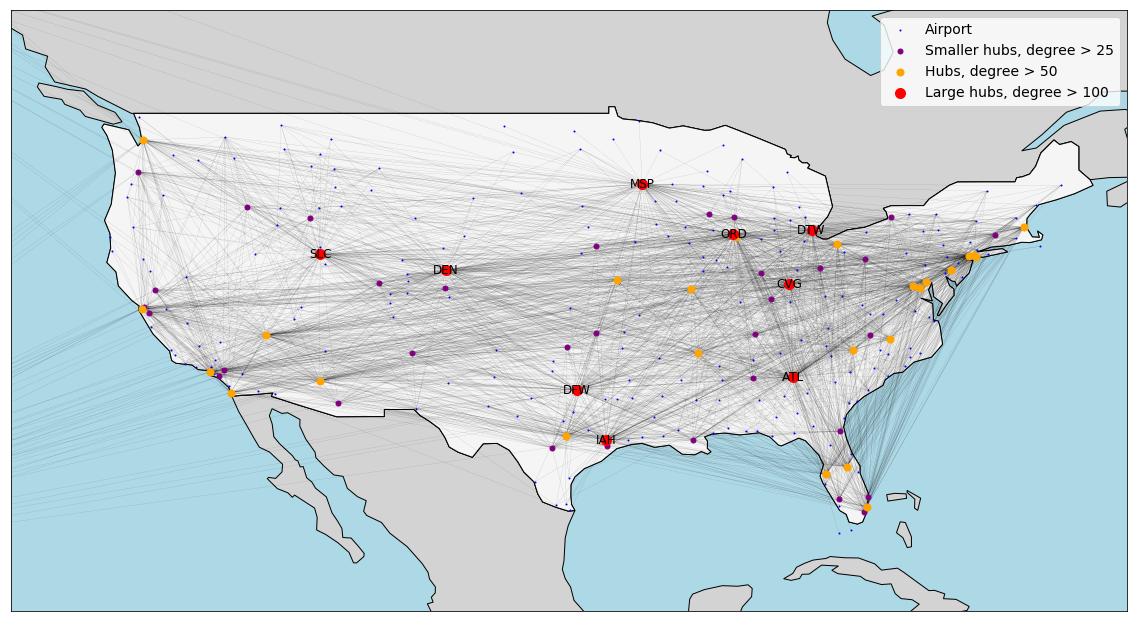

In [80]:
fig, ax = plt.subplots(figsize = (20,12))
world.plot(ax = ax, color = "lightgrey", edgecolor = "black")
US.plot(ax = ax, color = "whitesmoke", edgecolor = "black")
plt.xlim(-130,-65)
plt.ylim(20,55)
ax.set_facecolor("lightblue")
plt.xticks([])
plt.yticks([])
nx.draw_networkx_edges(Network, pos, with_labels=False, width=0.05, ax = ax)
nx.draw_networkx_nodes(Network, pos, with_labels=False, node_size=1, ax = ax, node_color = "blue").set_label("Airport")
nx.draw_networkx_nodes(Network, pos, nodelist = hubs_small, with_labels=False, node_size=25, ax = ax, node_color = "purple").set_label("Smaller hubs, degree > 25")
nx.draw_networkx_nodes(Network, pos, nodelist = hubs, with_labels=False, node_size=50, ax = ax, node_color = "orange").set_label("Hubs, degree > 50")
nx.draw_networkx_nodes(Network, pos, nodelist = hubs_large, with_labels=False, node_size=100, ax = ax, node_color = "red").set_label("Large hubs, degree > 100")
nx.draw_networkx_labels(Network.subgraph(hubs_large), pos_large)

plt.legend(fontsize = 14)
fig.savefig('Figures/map_general.png', bbox_inches='tight')
plt.show()